<a href="https://colab.research.google.com/github/yoii18/KaggleModels/blob/main/Kaggle_PGS_S4E1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.3 MB/s eta 0:00:00


In [3]:
!pip install colorama

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

import warnings
warnings.filterwarnings("ignore")

In [56]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2', '#fee08b',
           '#66c2a5', '#5e4fa2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('fivethirtyeight')

In [6]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E1/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E1/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E1/sample_submission.csv')

original_data = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E1/Churn_Modelling.csv')

In [7]:
train_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,165034.000000,82516.500000,47641.356500,0.000000,41258.250000,82516.500000,123774.750000,165033.000000
CustomerId,165034.000000,15692005.019026,71397.816791,15565701.000000,15633141.000000,15690169.000000,15756824.000000,15815690.000000
CreditScore,165034.000000,656.454373,80.103340,350.000000,597.000000,659.000000,710.000000,850.000000
Age,165034.000000,38.125888,8.867205,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,165034.000000,5.020353,2.806159,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,165034.000000,55478.086689,62817.663278,0.000000,0.000000,0.000000,119939.517500,250898.090000
NumOfProducts,165034.000000,1.554455,0.547154,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,165034.000000,0.753954,0.430707,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,165034.000000,0.497770,0.499997,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,165034.000000,112574.822734,50292.865585,11.580000,74637.570000,117948.000000,155152.467500,199992.480000


In [8]:
test_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,110023.000000,220045.000000,31761.048671,165034.000000,192539.500000,220045.000000,247550.500000,275056.000000
CustomerId,110023.000000,15692096.605101,71684.990992,15565701.000000,15632859.000000,15690175.000000,15756926.000000,15815690.000000
CreditScore,110023.000000,656.530789,80.315415,350.000000,597.000000,660.000000,710.000000,850.000000
Age,110023.000000,38.122205,8.861550,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,110023.000000,4.996637,2.806148,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,110023.000000,55333.611354,62788.519675,0.000000,0.000000,0.000000,120145.605000,250898.090000
NumOfProducts,110023.000000,1.553321,0.544714,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,110023.000000,0.753043,0.431244,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,110023.000000,0.495233,0.499980,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,110023.000000,112315.147765,50277.048244,11.580000,74440.325000,117832.230000,154631.350000,199992.480000


In [9]:
original_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
RowNumber,10002.000000,5001.499600,2887.472338,1.000000,2501.250000,5001.500000,7501.750000,10000.000000
CustomerId,10002.000000,15690933.450110,71931.769345,15565701.000000,15628524.750000,15690732.000000,15753225.500000,15815690.000000
CreditScore,10002.000000,650.555089,96.661615,350.000000,584.000000,652.000000,718.000000,850.000000
Age,10001.000000,38.922311,10.487200,18.000000,32.000000,37.000000,44.000000,92.000000
Tenure,10002.000000,5.012498,2.891973,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,10002.000000,76491.112875,62393.474144,0.000000,0.000000,97198.540000,127647.840000,250898.090000
NumOfProducts,10002.000000,1.530194,0.581639,1.000000,1.000000,1.000000,2.000000,4.000000
HasCrCard,10001.000000,0.705529,0.455827,0.000000,0.000000,1.000000,1.000000,1.000000
IsActiveMember,10001.000000,0.514949,0.499801,0.000000,0.000000,1.000000,1.000000,1.000000
EstimatedSalary,10002.000000,100083.331145,57508.117802,11.580000,50983.750000,100185.240000,149383.652500,199992.480000


# 2. EDA

### 2.1 Null Values
Ways to handle null values:
1. Delete
2. Impute

In [15]:
def null_displot(df, title=None):
  sns.displot(data=df.isnull().melt(value_name='missing'),
            y='variable',
            hue='missing',
            multiple='fill',
            height=8,
            aspect=1.6)
  plt.axvline(0.4, color='r')
  plt.title(f"Null Values in {title} Data", fontsize=13)
  plt.show()

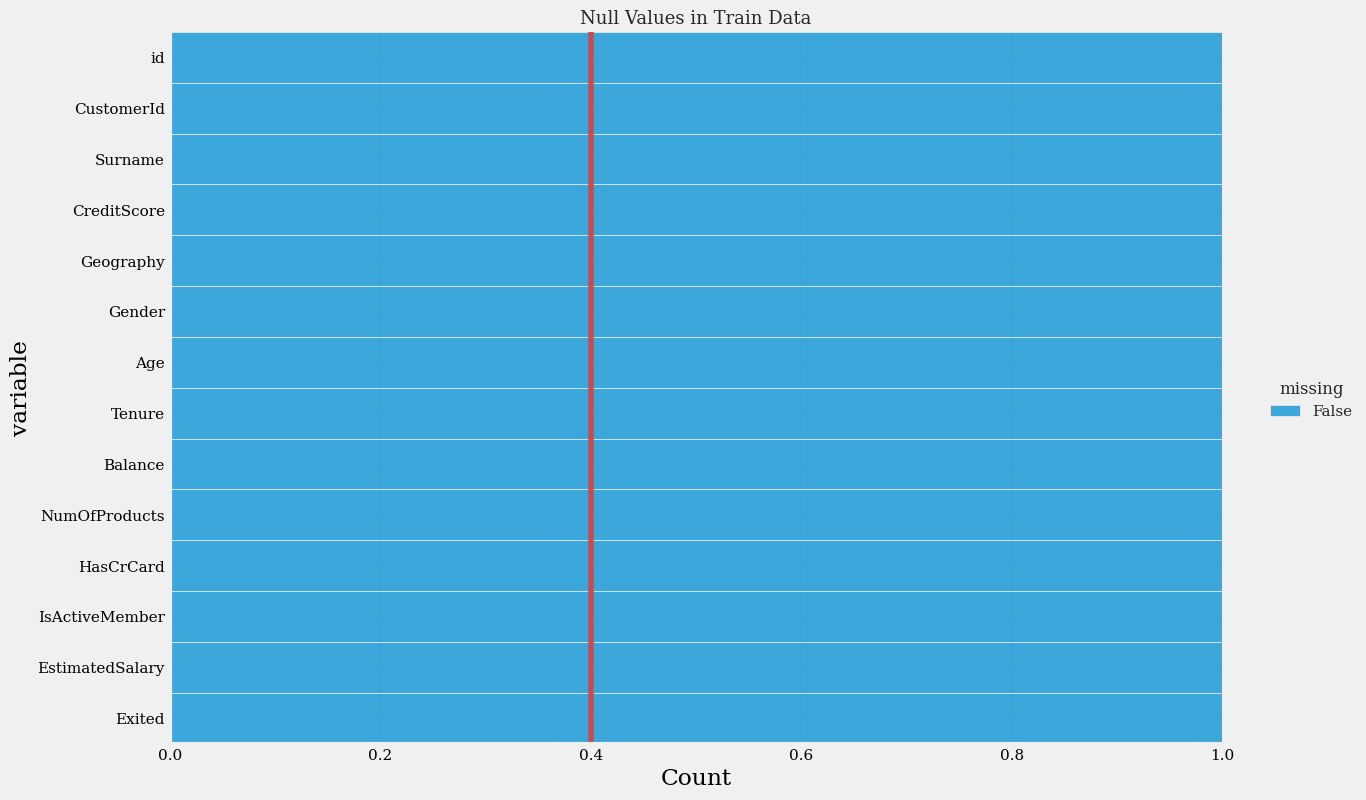

In [16]:
null_displot(train_data, 'Train')

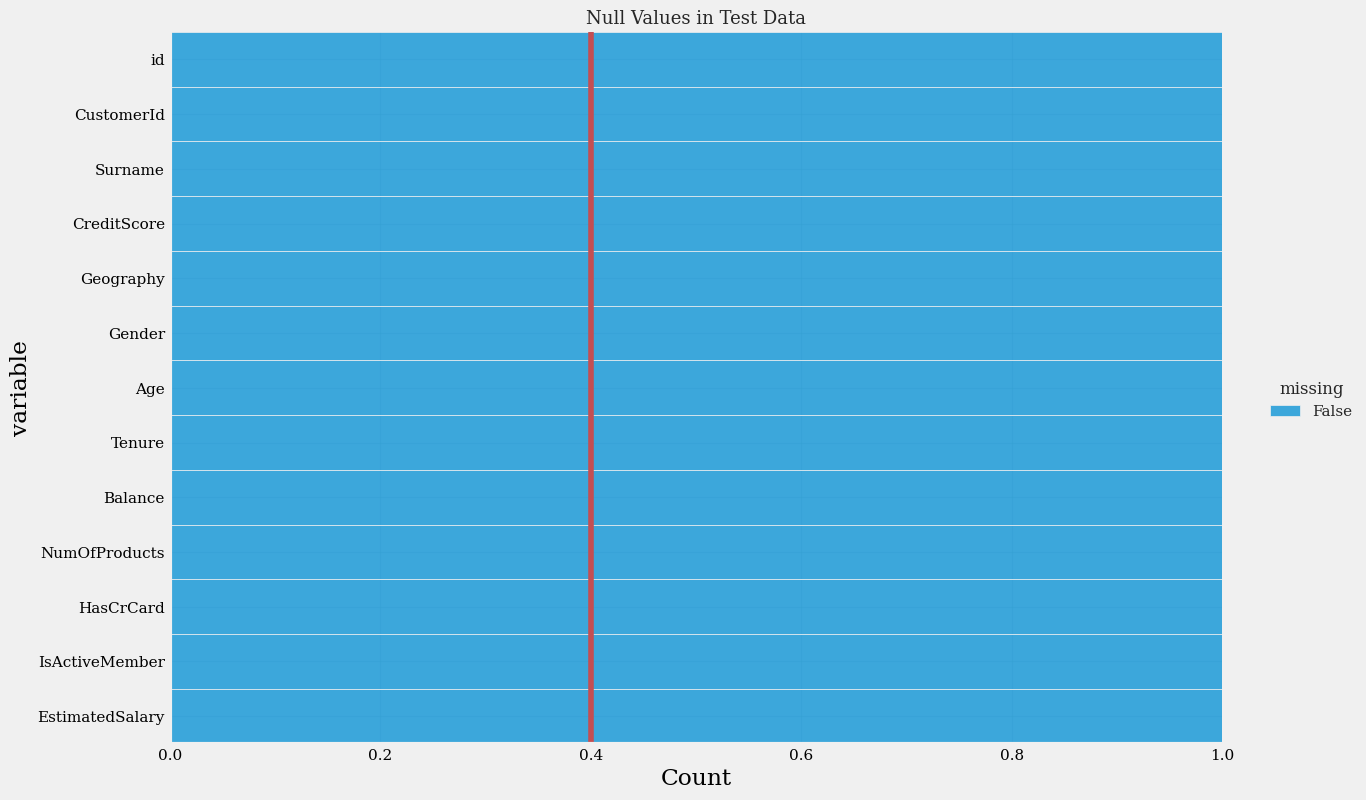

In [17]:
null_displot(test_data, 'Test')

In [28]:
def target_plot(df, title=None):
  f, ax = plt.subplots(1,2,figsize=(8,3))
  df['Exited'].value_counts().plot.pie(autopct='%1.1f%%',
                                       wedgeprops={'width': 0.3},
                                       startangle=0,
                                       ax=ax[0],
                                       shadow=False)
  ax[0].set_ylabel('')
  sns.countplot(x='Exited', data=df, ax=ax[1])
  plt.suptitle(f'Target Value Anaysis - {title} Data')
  plt.show()

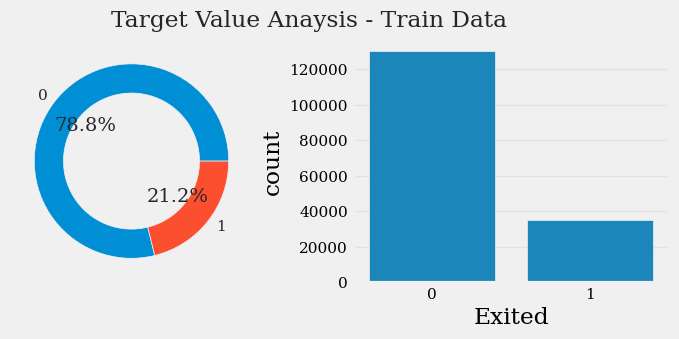

In [29]:
target_plot(train_data, 'Train')

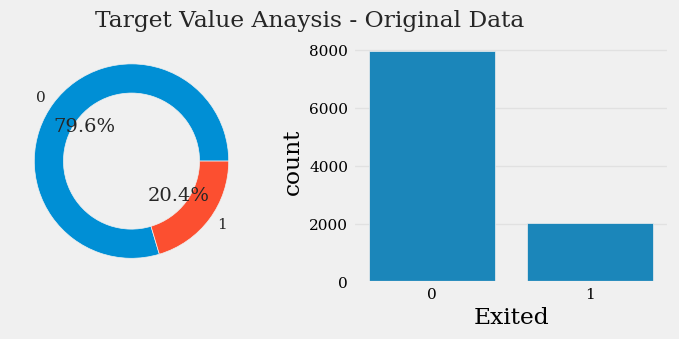

In [30]:
target_plot(original_data, 'Original')

In [40]:
unique_counts = train_data.nunique()
threshold = 12
cat_cols = unique_counts[unique_counts<=threshold].index.tolist()
num_cols = unique_counts[unique_counts>threshold].index.tolist()

remove_cols = ['Exited', 'id', 'Surname', 'CustomerId']

for col in remove_cols:
  if (col in cat_cols):
    cat_cols.remove(col)
  if col in num_cols:
    num_cols.remove(col)

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [57]:
def cat_col_plot(df, title=None):
  for col in cat_cols:
    fig, ax = plt.subplots(1, 2, figsize=(9,3))
    df[col].value_counts().plot.pie(autopct='%1.1f%%',
                                    wedgeprops={'width': 0.5},
                                    startangle=0,
                                    ax=ax[0],
                                    shadow=False,
                                    textprops={'fontsize': 9},
                                    colors=palette)
    ax[0].set_ylabel('')
    sns.countplot(x=col, data=df, ax=ax[1], palette=palette)
    ax[1].set_xlabel(col, fontsize=11)
    ax[1].set_ylabel('Count', fontsize=11)
    plt.suptitle(f'{title} - {col} Analysis', fontsize=11)
    plt.tight_layout()
    plt.show()
    print("\n")

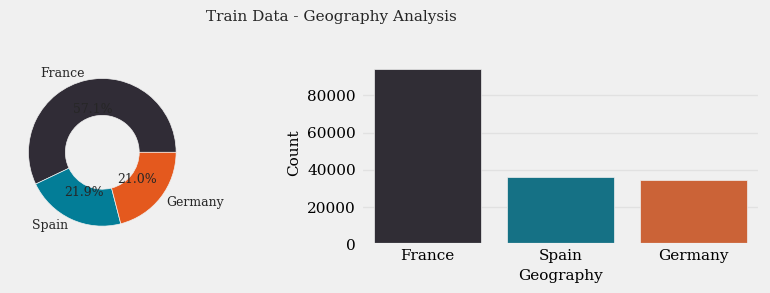

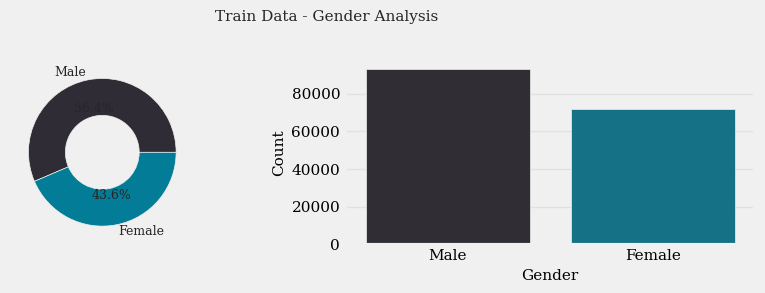

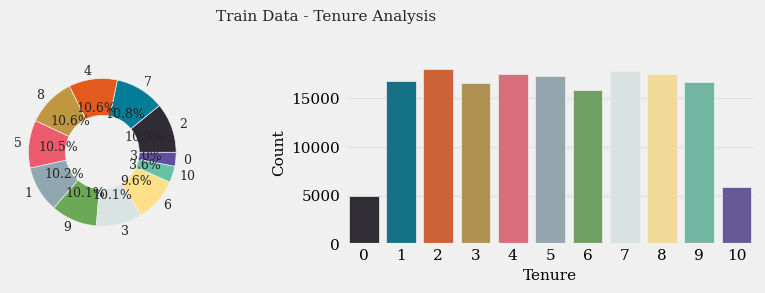

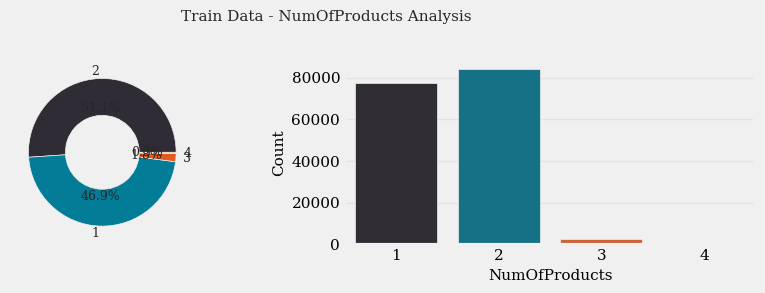

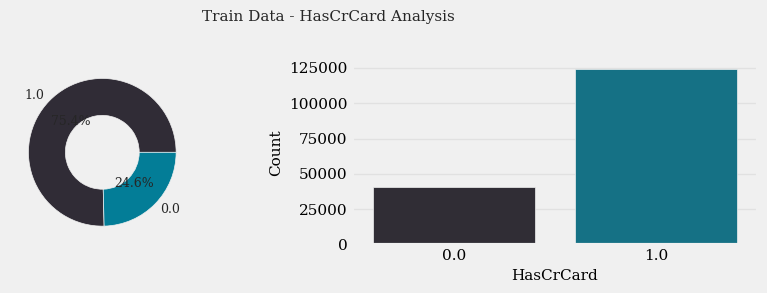

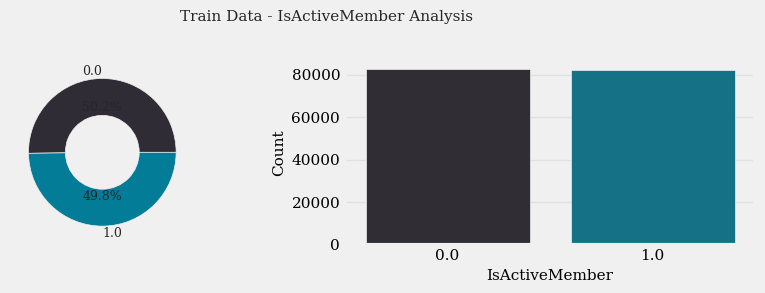

In [58]:
cat_col_plot(train_data, 'Train Data')

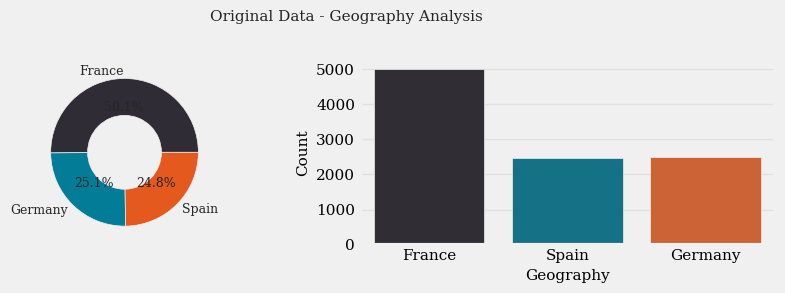

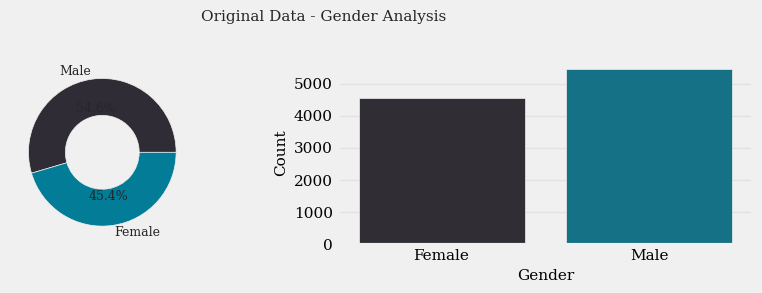

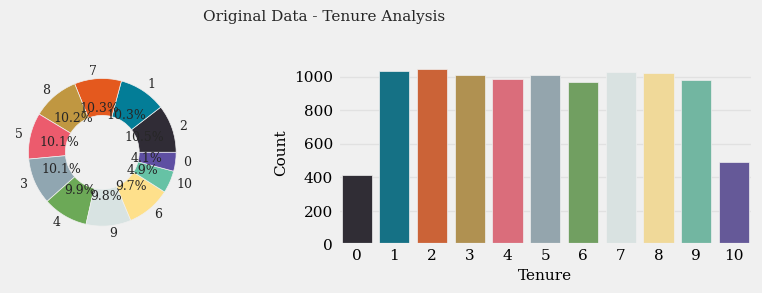

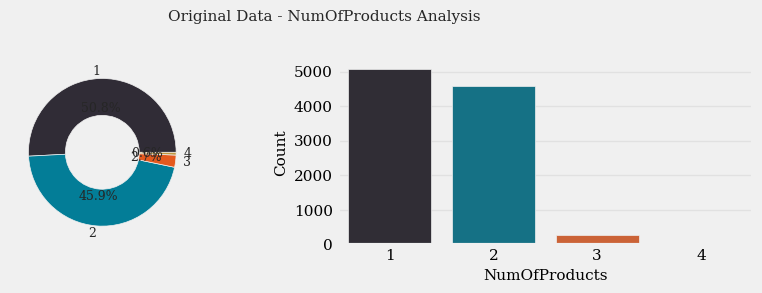

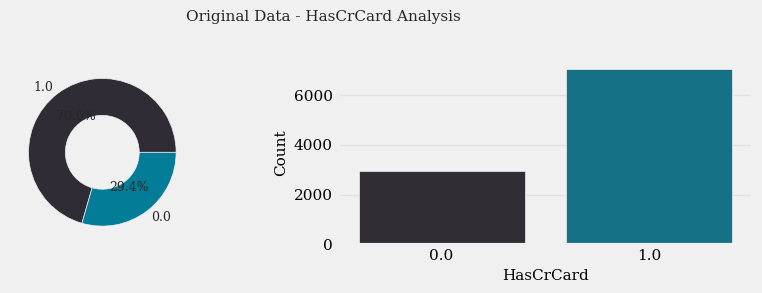

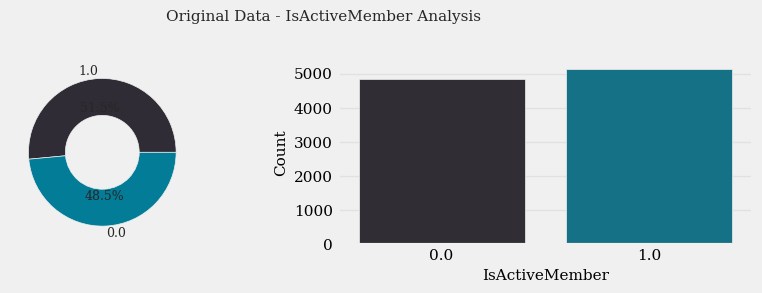

In [59]:
cat_col_plot(original_data, 'Original Data')

In [65]:
def num_cols_plot(df, title=None):
  for col in num_cols:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=df, x=col, hue="Exited", bins=50, kde=True)
    plt.suptitle(f'{title} - {col}')
    plt.show()
    print("\n")

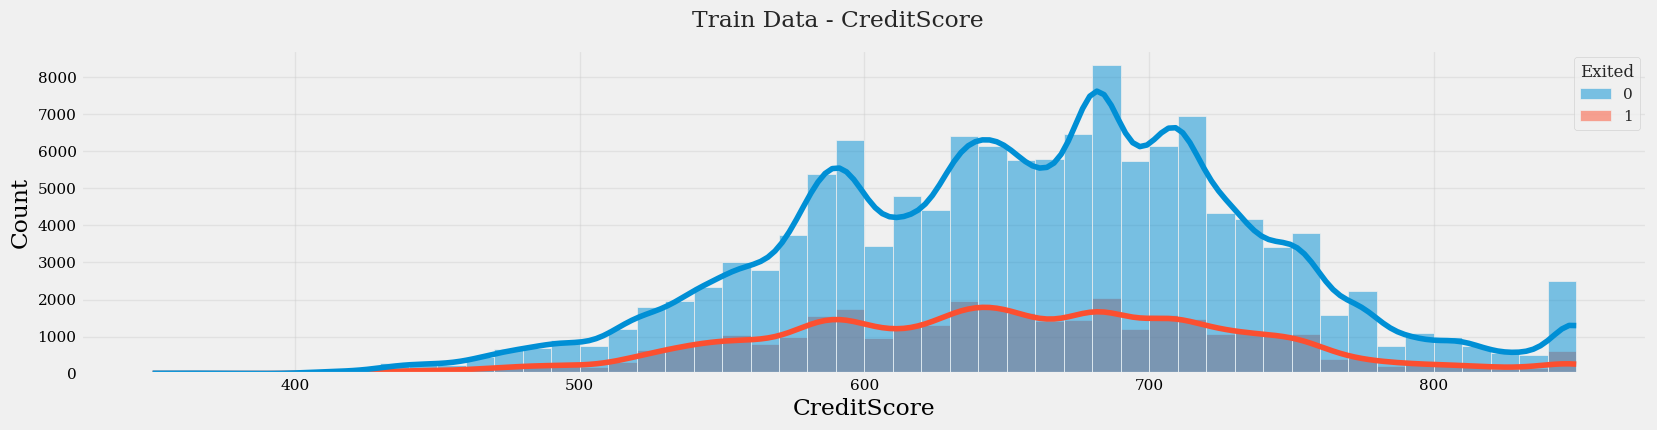

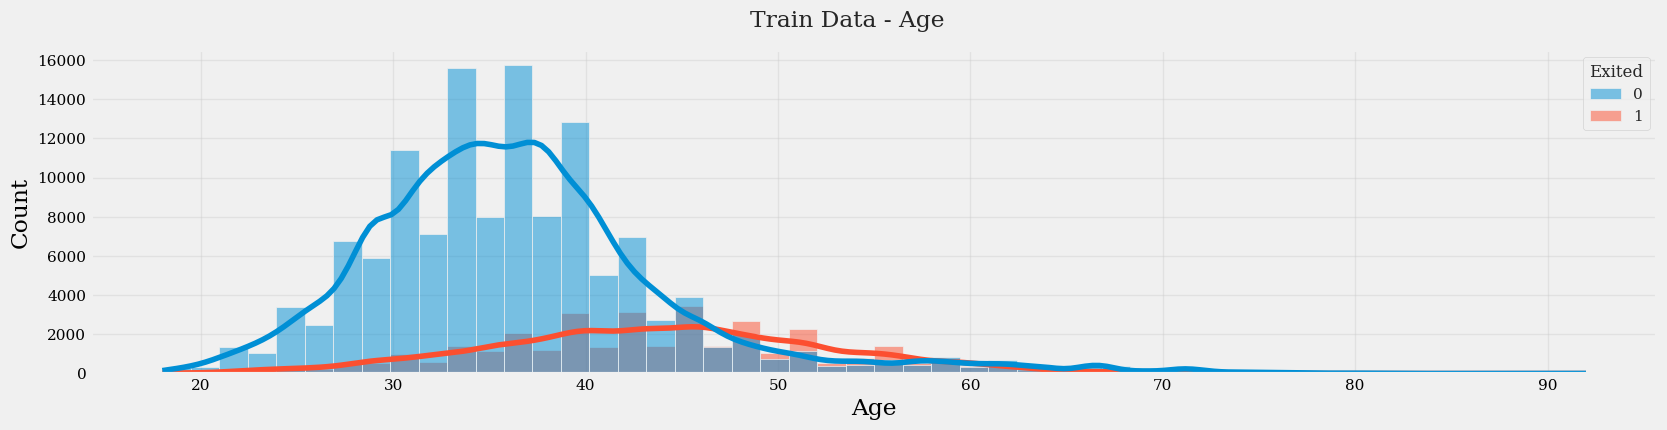

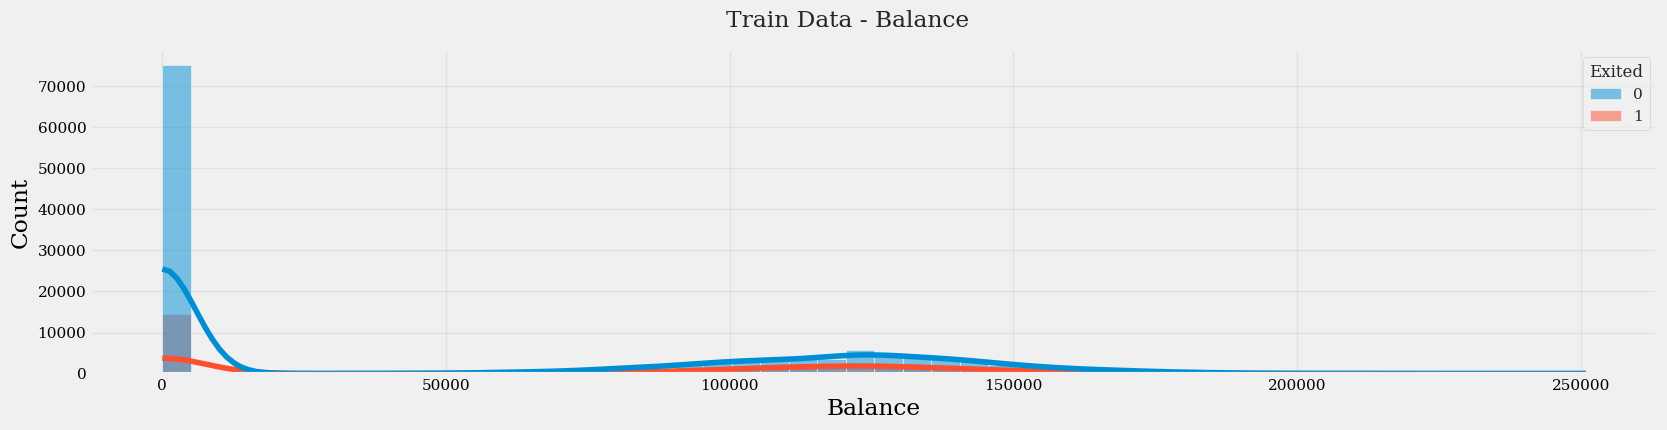

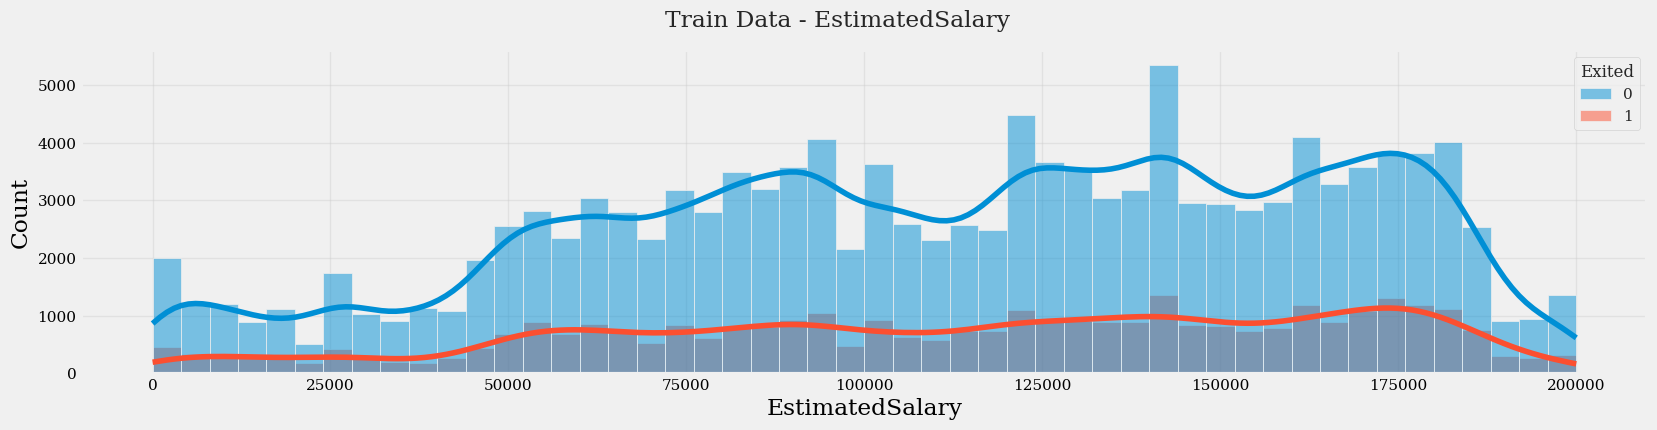

In [66]:
num_cols_plot(train_data, 'Train Data')

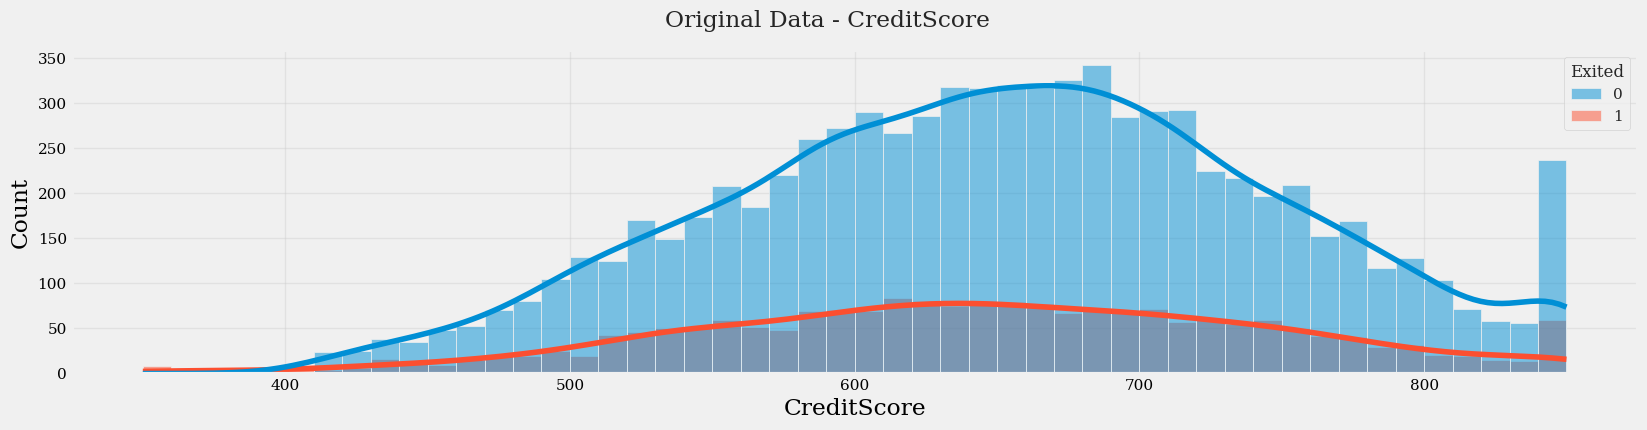

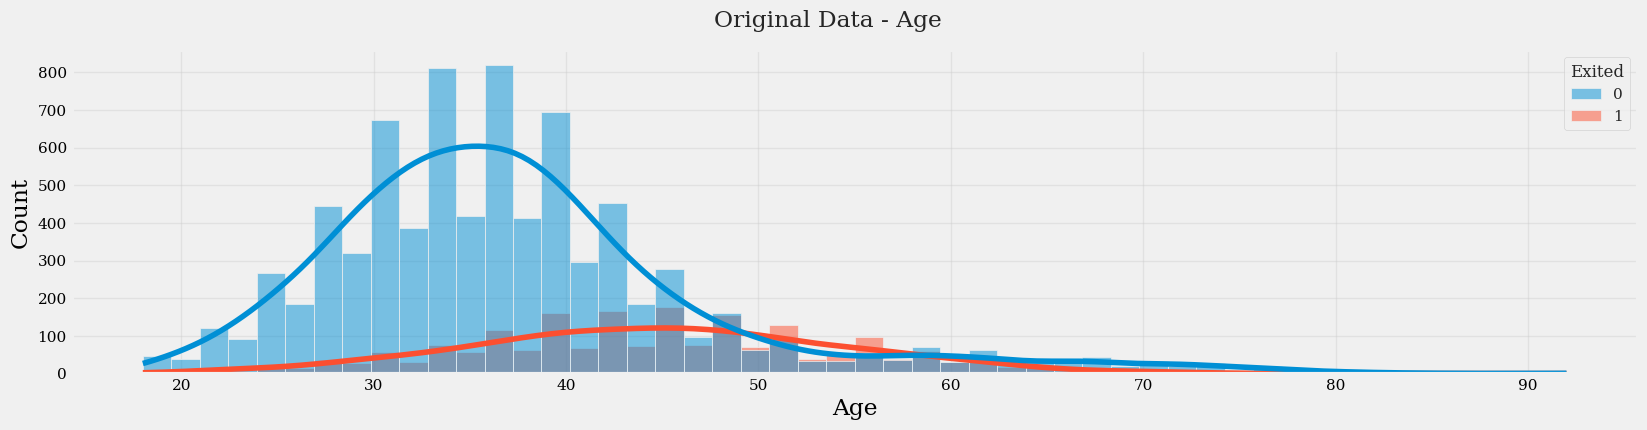

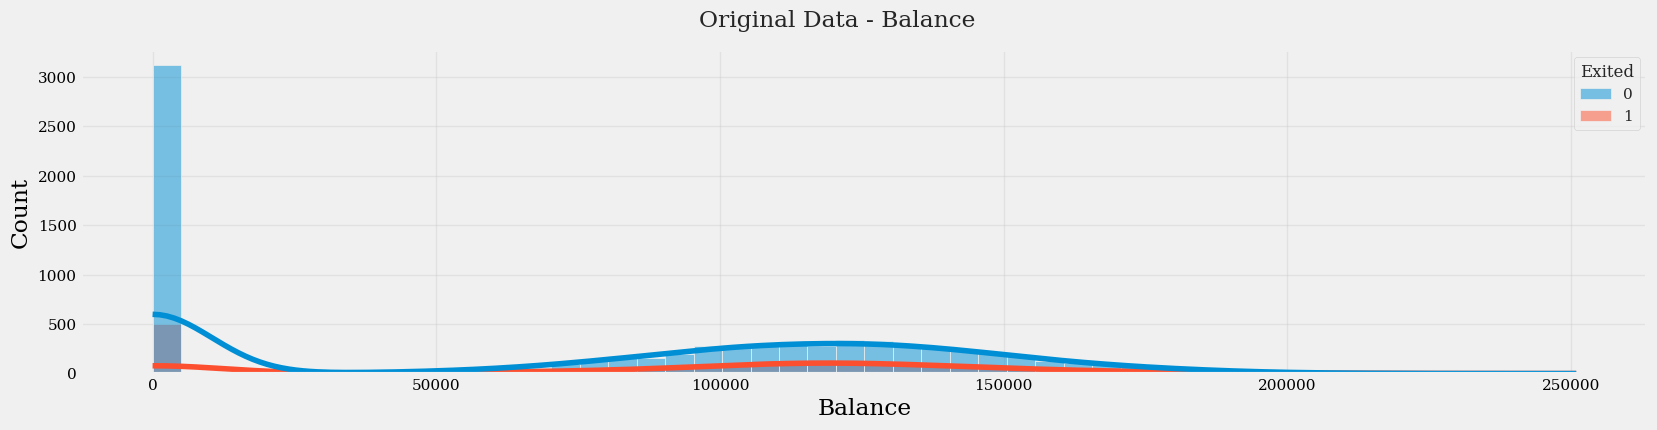

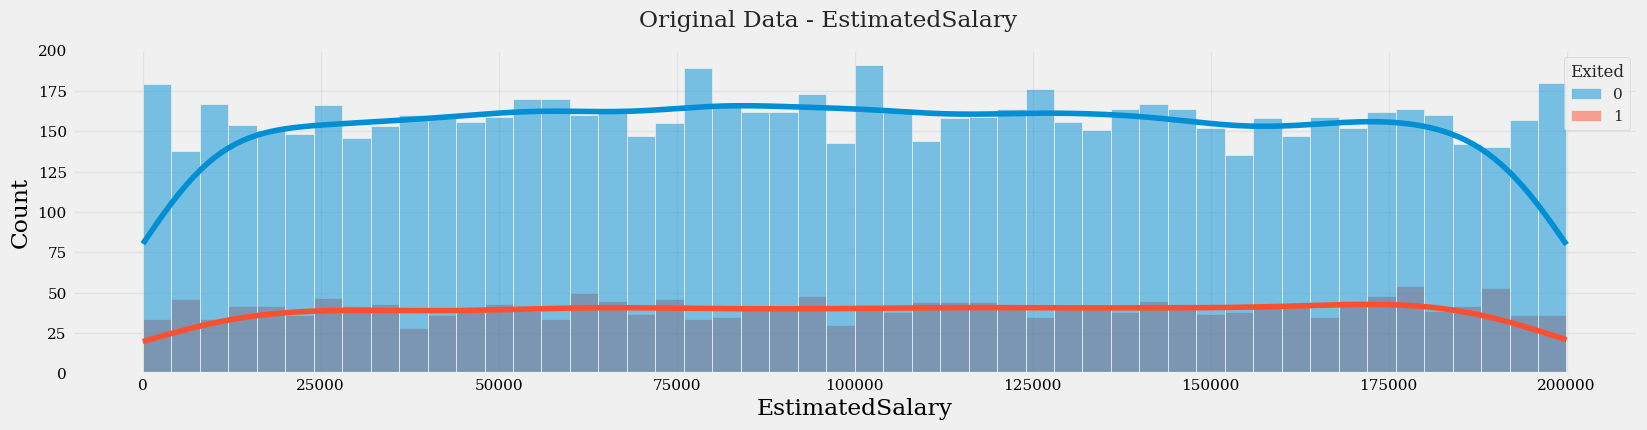

In [67]:
num_cols_plot(original_data, 'Original Data')

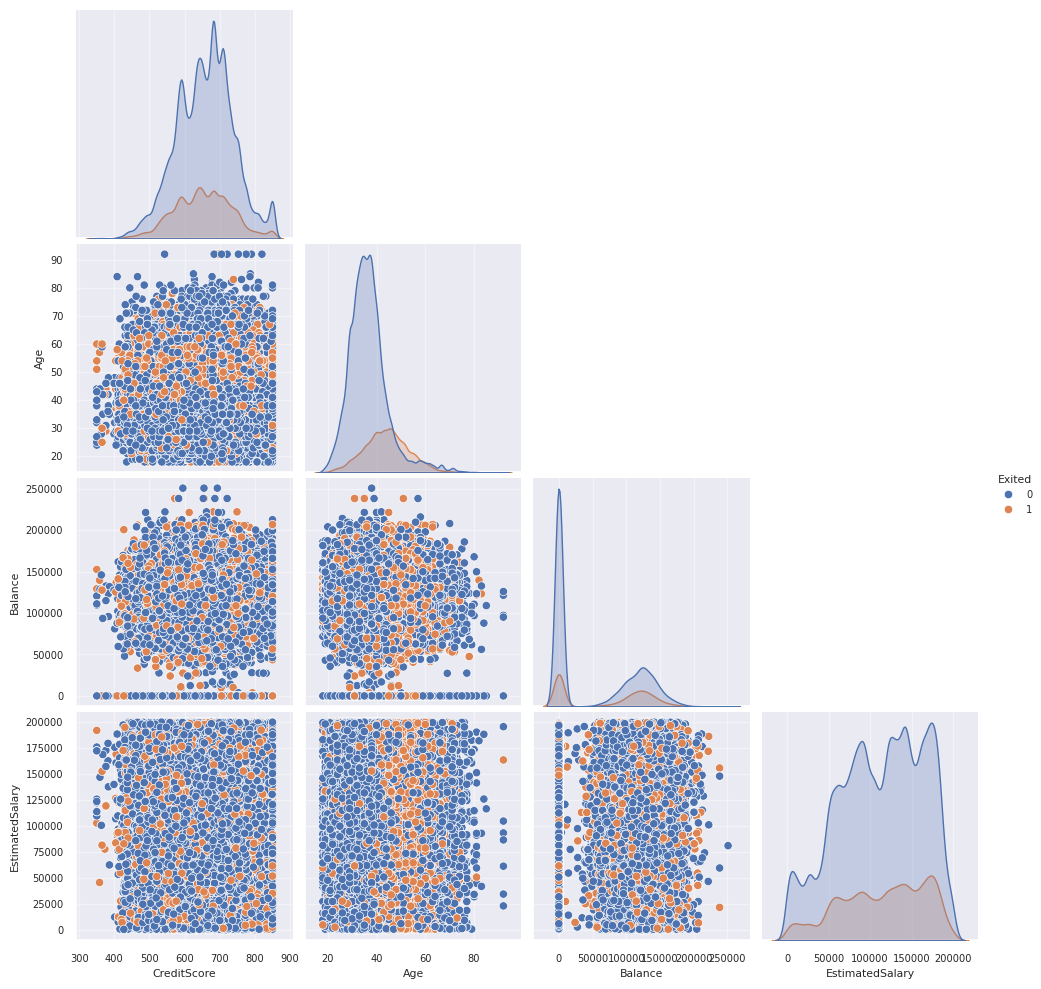

In [73]:
df3 = train_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']].copy()
sns.set(font_scale=0.65)
sns.pairplot(df3, hue="Exited", corner=True)
plt.show()

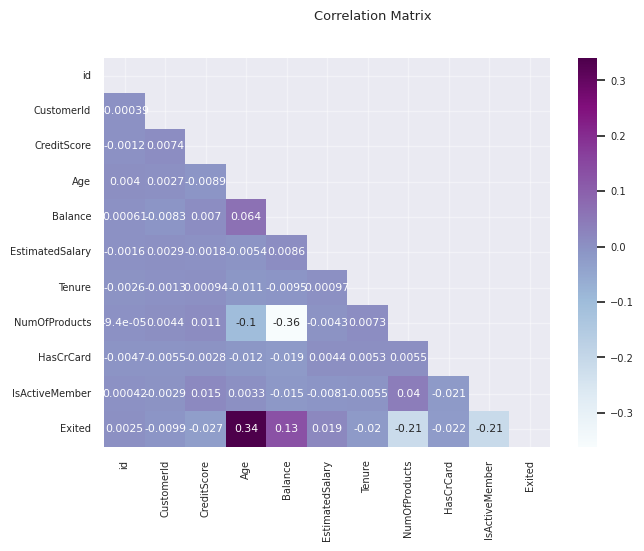

In [72]:
cols = ['id', 'CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary',
       'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']

corr = train_data[cols].corr()
mask = np.triu(np.ones_like(corr))
sns.set(font_scale = 0.65)
sns.heatmap(corr, mask=mask, annot=True, cmap='BuPu')
plt.suptitle('Correlation Matrix')
plt.show()

In [74]:
X = train_data.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = train_data['Exited']

In [75]:
X_encoded = pd.get_dummies(X, columns=['Geography',
                                       'Gender',
                                       'IsActiveMember',
                                       'HasCrCard',
                                       'NumOfProducts'])

X_encoded.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsActiveMember_0.0,IsActiveMember_1.0,HasCrCard_0.0,HasCrCard_1.0,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,668,33.0,3,0.00,181449.97,1,0,0,0,1,1,0,0,1,0,1,0,0
1,627,33.0,1,0.00,49503.50,1,0,0,0,1,0,1,0,1,0,1,0,0
2,678,40.0,10,0.00,184866.69,1,0,0,0,1,1,0,0,1,0,1,0,0
3,581,34.0,2,148882.54,84560.88,1,0,0,0,1,0,1,0,1,1,0,0,0
4,716,33.0,5,0.00,15068.83,0,0,1,0,1,0,1,0,1,0,1,0,0


In [76]:
test_data = test_data.drop(['id', 'CustomerId', 'Surname'], axis=1)
test_data.head()

X_test_encoded = pd.get_dummies(test_data, columns=['Geography',
                                       'Gender',
                                       'IsActiveMember',
                                       'HasCrCard',
                                       'NumOfProducts'])

X_test_encoded.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsActiveMember_0.0,IsActiveMember_1.0,HasCrCard_0.0,HasCrCard_1.0,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,586,23.0,2,0.00,160976.75,1,0,0,1,0,0,1,1,0,0,1,0,0
1,683,46.0,2,0.00,72549.27,1,0,0,1,0,1,0,0,1,1,0,0,0
2,656,34.0,7,0.00,138882.09,1,0,0,1,0,1,0,0,1,0,1,0,0
3,681,36.0,8,0.00,113931.57,1,0,0,0,1,1,0,0,1,1,0,0,0
4,752,38.0,10,121263.62,139431.00,0,1,0,0,1,1,0,0,1,1,0,0,0


In [77]:
sum(y)/len(y)

0.21159882206090866

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [82]:
sum(y_train)/len(y_train)

0.21160169662694406

In [83]:
sum(y_test)/len(y_test)

0.211590198502145

In [86]:
clf_xgb_v1 = xgb.XGBClassifier(objective='binary:logistic',
                            # missing=None,
                            seed=42)

clf_xgb_v1.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.87456
[1]	validation_0-auc:0.88092
[2]	validation_0-auc:0.88303
[3]	validation_0-auc:0.88468
[4]	validation_0-auc:0.88556
[5]	validation_0-auc:0.88591
[6]	validation_0-auc:0.88628
[7]	validation_0-auc:0.88674
[8]	validation_0-auc:0.88708
[9]	validation_0-auc:0.88711
[10]	validation_0-auc:0.88730
[11]	validation_0-auc:0.88754
[12]	validation_0-auc:0.88765
[13]	validation_0-auc:0.88772
[14]	validation_0-auc:0.88782
[15]	validation_0-auc:0.88793
[16]	validation_0-auc:0.88806
[17]	validation_0-auc:0.88805
[18]	validation_0-auc:0.88794
[19]	validation_0-auc:0.88796
[20]	validation_0-auc:0.88807
[21]	validation_0-auc:0.88815
[22]	validation_0-auc:0.88811
[23]	validation_0-auc:0.88816
[24]	validation_0-auc:0.88814
[25]	validation_0-auc:0.88807
[26]	validation_0-auc:0.88806
[27]	validation_0-auc:0.88796
[28]	validation_0-auc:0.88798
[29]	validation_0-auc:0.88798
[30]	validation_0-auc:0.88799
[31]	validation_0-auc:0.88798
[32]	validation_0-auc:0.88797


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)